In [1]:
import os
import sys
import time
import itertools
import numpy as np

# Torch
import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
print("Torch Version:", torch.__version__)

sys.path.append("../../")

# Planning
sys.path.append("../Planning/")
import Planners as Planners

# Control
sys.path.append("../Acting/")
import TrajectorySamplers as TrajectorySamplers

# Model
sys.path.append("../Learning/")
import Models as Models
from Models import weights_init

# Simple RL
from simple_rl.tasks import NavigationWorldMDP
from simple_rl.tasks.navigation.NavigationWorldMDP import NavigationWorldMDP, generate_states, NavigationWorldState

# IRL
sys.path.append("../MLIRL")
from MLIRL import MLIRL

# MaxEnt
sys.path.append("../MaxEntIRL")
from MaxEntIRL import *

# Eval
sys.path.append("../utils/")
from Evaluation import *

from helper import convert_to_grid, plot_irl_gridworld, plot_irl_results

import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable
# style.use('classic')
%matplotlib inline

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 55

%matplotlib inline
%load_ext autoreload
%autoreload 2


Torch Version: 0.5.0a0+ab6afc2


# Expert Demonstrations

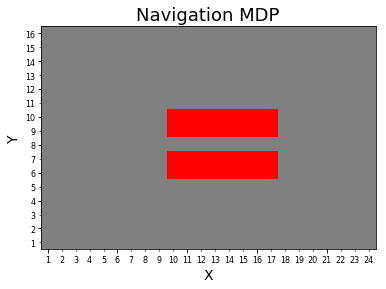

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1325c4160>)

In [2]:
def shortest_path_fn(s, g, nvmdp, living_reward=-0.01):
    
    R_s = nvmdp._reward_func_state_only
    T = nvmdp.transition_func
    A = nvmdp.get_actions()
    return Planners.astar_find_path(
        s, g, A, T, cost_fn=lambda s: -R_s(s),
        heuristic_fn=lambda s1, s2: (living_reward) * np.linalg.norm(np.array(s1) - np.array(s2)))

np.random.seed(1)
torch.manual_seed(1)
W, H = 24,16
obstacle = lambda x, y, w, h: [(x+i, y+j) for j in range(h) for i in range(w)]
state_cells = list(itertools.chain(*[o() for o in generate_states(
                              W, H, n_states=1, 
                              obstacle_w_mu=W, obstacle_w_std=0.0, 
                              obstacle_h_mu=H, obstacle_h_std=0.0,
                              buffer_w=0, buffer_h=0, max_search_tries=1)]))

obstacles_states = obstacle(10,6,8,2) + obstacle(10,9,8,2)
remaining_states = list(set(state_cells) - set(obstacles_states))


traj_with_temperature = True
nvmdp_real = NavigationWorldMDP(
    
    width = W, height = H,
    nav_cell_types = ["gray", "red"],
    nav_cell_rewards = [-0.1, -0.8], # To create separate indicator feature for each obstacle cell.
    nav_cell_p_or_locs = [remaining_states, obstacles_states],
#     nav_cell_types = ["gray"],
#     nav_cell_rewards = [-0.01], # To create separate indicator feature for each obstacle cell.
#     nav_cell_p_or_locs = [1.],
    goal_cell_types = [],
    goal_cell_rewards = [],
    goal_cell_locs = [],
    slip_prob = 0.0, step_cost = 0,
    gamma = 0.95
)

nvmdp_real.visualize_grid()

In [3]:
"""
Shortest Paths
"""
start, goal = NavigationWorldState(5,8), NavigationWorldState(20,8)
if not traj_with_temperature:
    trajectories = TrajectorySamplers.sample_shortest_path_trajectories(
        [NavigationWorldState(2,6), NavigationWorldState(2,8)], [NavigationWorldState(10,6), NavigationWorldState(10,7)], 
        lambda s,g,mdp=nvmdp_real: shortest_path_fn(s,g,mdp))
    trajectories_states = [list(zip(*traj))[0] for traj in trajectories]
else:
    
    EXPERT_TEMP = 0.5
    gamma = 0.97
    N_TRAJ = 4
    S = nvmdp_real.get_all_states()
    s_to_idx = {v:k for k,v in enumerate(S)}
    A = nvmdp_real.get_actions()
    T = nvmdp_real.transition_func
    R_real_s = nvmdp_real._reward_func_state_only
    R_real = torch.tensor([float(R_real_s(s)) for s in S], requires_grad=False)
    policy = lambda Q, temp=EXPERT_TEMP: Planners.log_boltzmann_dist(Q, temp)
    log_Pi, V, Q, s_to_idx, a_to_idx, iterno = Planners.value_iteration(
        S, A, R_real, lambda s,a: [(T(s,a), 1.)], policy, gamma, 200, start, goal, verbose=True)

    trajectories = TrajectorySamplers.sample_trajectories(N_TRAJ, S, A, T, [start]*N_TRAJ, log_Pi.detach().numpy(),
                                         goal, greedy_selection=False, values=V)
    trajectories_states = [list(zip(*traj))[0] for traj in trajectories]

Running VI [ ... ] VI converged @ 94.


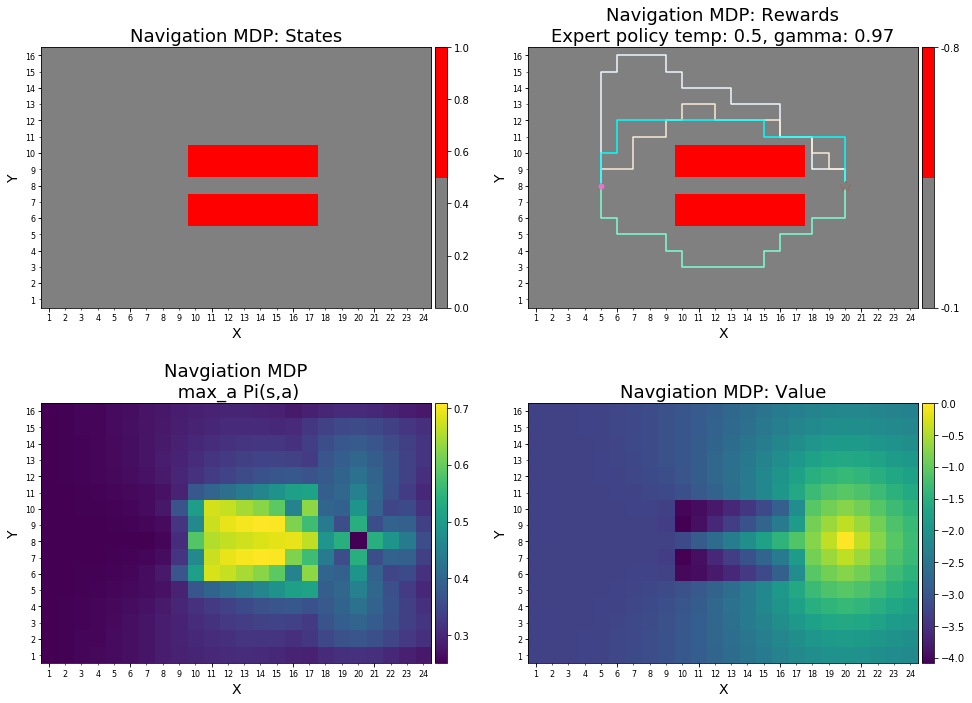

In [4]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(221)
fig, ax = nvmdp_real.visualize_grid(fig=fig, ax=ax, 
                                    show_colorbar=True, end_marker="*", 
                                    subplot_str="121", title="Navigation MDP: States")
ax = fig.add_subplot(222)
nvmdp_real.visualize_grid(fig=fig, ax=ax, trajectories=trajectories_states, end_marker="*",
                          show_colorbar=True, show_rewards_colorbar=True, plot=False,
                          subplot_str="122", title="Navigation MDP: Rewards\nExpert policy temp: {}, gamma: {}".format(EXPERT_TEMP, gamma))

ax = fig.add_subplot(223)
Pi_grid = convert_to_grid(nvmdp_real, S, torch.exp(log_Pi).max(dim=1)[0].detach().numpy().tolist())
nvmdp_real.visualize_grid(fig=fig, ax=ax, values=Pi_grid, state_space_cmap=False, show_colorbar=True, plot=False,
                          title="Navgiation MDP\n max_a Pi(s,a)")

ax = fig.add_subplot(224)
V_grid = convert_to_grid(nvmdp_real, S, V)
nvmdp_real.visualize_grid(fig=fig, ax=ax, values=V_grid, state_space_cmap=False, show_colorbar=True, 
                          title="Navgiation MDP: Value")

fig.tight_layout()

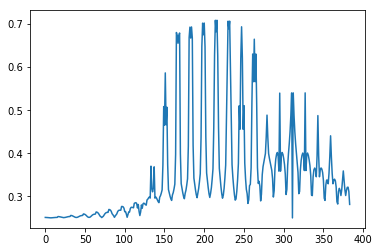

In [5]:
plt.plot(torch.exp(log_Pi).max(dim=1)[0].detach().numpy())

# IRL Navigation MDP

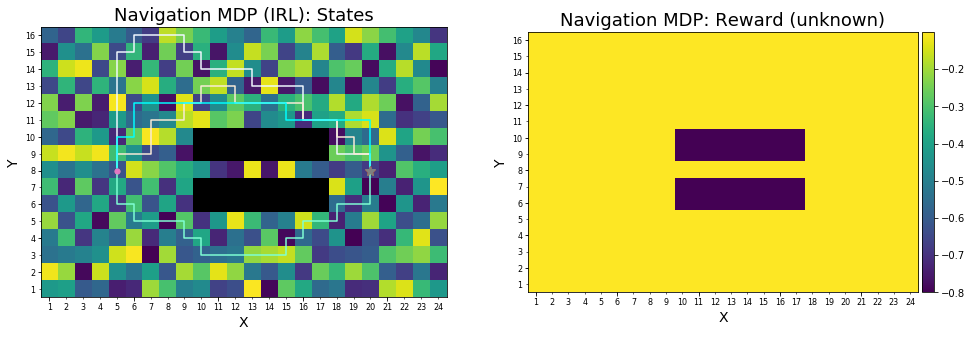

In [6]:
obstacles_states = obstacle(10,6,8,2) + obstacle(10,9,8,2)
remaining_states = list(set(state_cells) - set(obstacles_states))

# Unique Indicator features
nvmdp_irl = NavigationWorldMDP(
    
    width = W, height = H,
    nav_cell_types = ["black", *range(len(remaining_states))],
    nav_cell_rewards = [-1., *[-0.01]*len(remaining_states)], # To create separate indicator feature for each obstacle cell.
    nav_cell_p_or_locs = [obstacles_states, *[[o] for o in remaining_states]],
    goal_cell_types = [],
    goal_cell_rewards = [],
    goal_cell_locs = [],
    slip_prob = 0.0, step_cost = 0,
    gamma = 0.95
)

## Overlapping Indicator features
# nvmdp_irl = NavigationWorldMDP(
    
#     width = W, height = H,
#     nav_cell_types = ["black", "white"],
#     nav_cell_rewards = [-1., -0.01], # To create separate indicator feature for each obstacle cell.
#     nav_cell_p_or_locs = [obstacles_states, 1.],
#     goal_cell_types = [],
#     goal_cell_rewards = [],
#     goal_cell_locs = [],
#     slip_prob = 0.0, step_cost = 0,
#     gamma = 0.95
# )
# shuffle state ids for better cmap representation of our problem.
# nvmdp_irl.map_state_cell_id = np.random.permutation(
#     nvmdp_irl.map_state_cell_id.reshape(1,-1).squeeze()).reshape(nvmdp_irl.height, nvmdp_irl.width)

## MDP Params ------------------
# States
S = nvmdp_irl.get_all_states()
s_to_idx = {v:k for k,v in enumerate(S)}
# Rewards
R_s = nvmdp_irl._reward_func_state_only
R = torch.tensor([float(R_s(s)) for s in S], requires_grad=True)
R_grid = convert_to_grid(nvmdp_irl, S, R)
# Actions
A = nvmdp_irl.get_actions()
a_to_idx = {a:i for i,a in enumerate(A)}
# Dynamics
T = nvmdp_irl.transition_func
# Features
state_ids = [nvmdp_irl.map_state_cell_id[nvmdp_irl._xy_to_rowcol(*s)] for s in S]
# linear_phi = torch.FloatTensor([state_id_to_linear_feature(s_id) for s_id in state_ids])
# non_linear_phi = torch.FloatTensor([state_id_to_non_linear_feature(s_id) for s_id in state_ids])
one_hot_phi = torch.FloatTensor([nvmdp_irl.feature_at_state(s) for s in S])
phi = one_hot_phi
phi_fn = lambda s: phi[s_to_idx[s]]
def states_generator(trajectory):
    return S

def dynamics_generator_deterministic(trajectory):
    return lambda s,a: [(T(s,a), 1.)]

def dynamics_generator_border_walls(trajectory):
    return lambda s,a: [(T(s,a), 1.) if (s.x != 1 and s.y != 1 and s.x != nvmdp_irl.width and s.y != nvmdp_irl.height) else (None, 1.) ]


# -------------------------------

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
fig, ax = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.viridis, plot=False,
                                   trajectories=trajectories_states,
                                   init_marker=".", end_marker="*",
                                   title="Navigation MDP (IRL): States")
ax = fig.add_subplot(122)
_ = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.viridis, 
                             title="Navigation MDP: Reward (unknown)", values=convert_to_grid(nvmdp_irl, S, R_real), 
                             state_space_cmap=False, show_colorbar=True)

In [7]:
# dynamics_generator = dynamics_generator_border_walls
dynamics_generator = dynamics_generator_deterministic

# MaxEnt IRL

In [8]:
phi_dim = len(phi_fn(S[0]))
temperature = 1.
gamma = 0.97
n_vi_iters = 150
vi_convergence_eps = 1e-4

n_maxent_iters = 10
n_mlirl_iters = n_maxent_iters
lr, weight_decay = 0.1, 0

Text(0.5,1,'R range: [-5.4165, -0.1000], \n  mean: -0.6797, median: -0.3716')

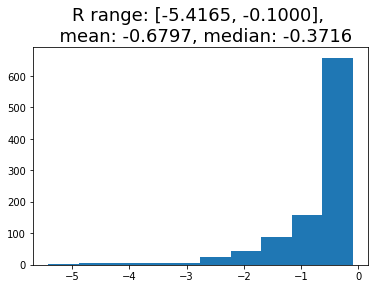

In [11]:
R_model = Models.LinearRewardModel_Squared_ReLU(phi_dim, -0.1, steep=0.05)
R_act = np.asarray([R_model(torch.FloatTensor(x)).item() for x in np.random.uniform(-10,10,(1000,phi_dim))])
plt.hist(R_act)
plt.title("R range: [{:.4f}, {:.4f}], \n  mean: {:.4f}, median: {:.4f}".format(R_act.min(), R_act.max(), R_act.mean(), np.median(R_act)))

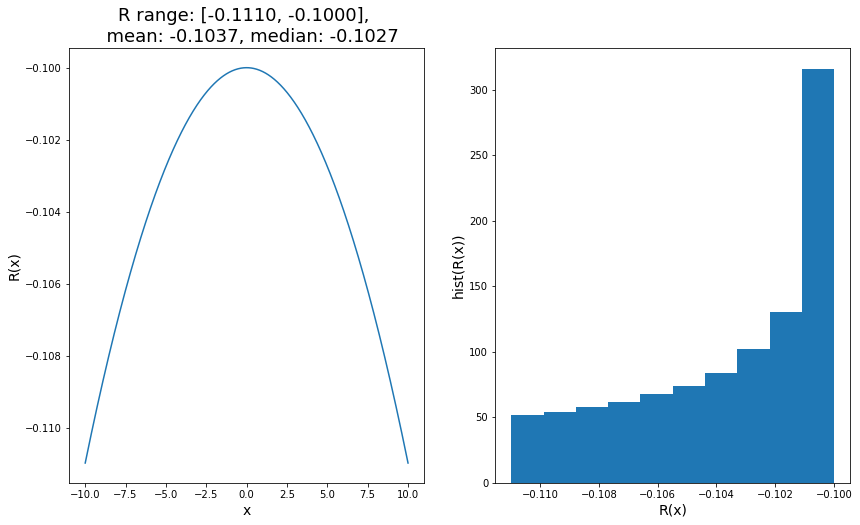

In [59]:
def plot_reward_fn(R_model, r_min, r_max, num=1000):
    features = np.linspace(r_min,r_max,1000)
    R_act = np.asarray([R_model(torch.FloatTensor([x])).item() for x in features])
    plt.figure(figsize=(14,8))
    plt.subplot(121)
    plt.plot(features, R_act)
    plt.xlabel("x")
    plt.ylabel("R(x)")
    plt.title("R range: [{:.4f}, {:.4f}], \n  mean: {:.4f}, median: {:.4f}".format(
        R_act.min(), R_act.max(), R_act.mean(), np.median(R_act)))
    plt.subplot(122)
    plt.hist(R_act)
    plt.ylabel("hist(R(x))")
    plt.xlabel("R(x)")
R_model = Models.LinearRewardModel_Squared_ReLU(1, -0.1, steep=0.05)
plot_reward_fn(R_model, -10, 10, num=1000)

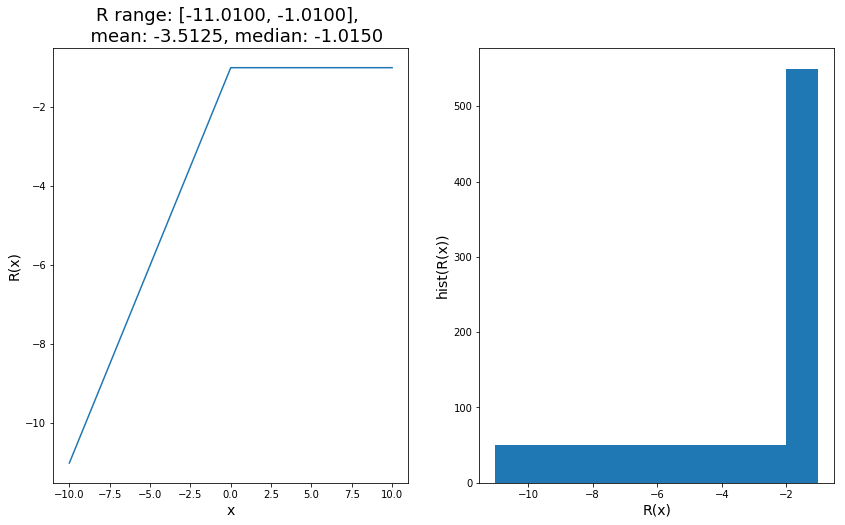

In [60]:
R_model = Models.LinearRewardModel_ReLU(1, -1.01, steep=1.)
R_model.apply(lambda x: weights_init(x, mu=-1, std=1e-12))
plot_reward_fn(R_model, -10, 10, num=1000)

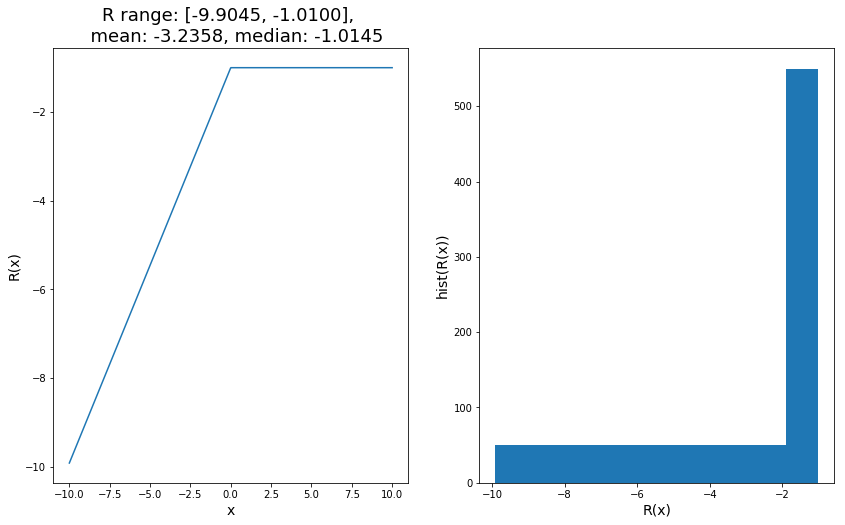

In [61]:
R_model = Models.LinearRewardModel_ReLU(1, -1.01, steep=1.)
# R_model.apply(lambda x: weights_init(x, mu=-1, std=1e-12))
plot_reward_fn(R_model, -10, 10, num=1000)

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x137b22c50>)

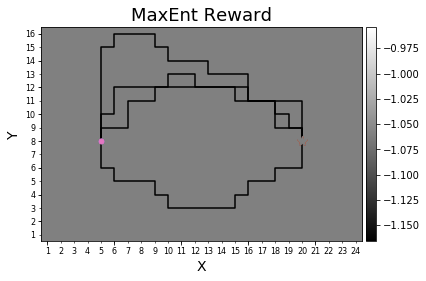

In [82]:
R_model = Models.LinearRewardModel_Squared_ReLU(phi_dim, -1.01, steep=0.05)
R_model.apply(lambda x: weights_init(x, mu=-1, std=1e-12))
R_grid = convert_to_grid(nvmdp_irl, S, torch.tensor([R_model(phi_fn(s)) for s in S], requires_grad=False))
nvmdp_irl.visualize_grid(cmap=plt.cm.gray, show_colorbar=True, plot=False,
                             trajectories=trajectories_states,
                             init_marker=".", end_marker="*", 
                             traj_marker="-k", traj_colors_auto=False,
                             title="MaxEnt Reward", values=R_grid,
                             state_space_cmap=False)

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x137640630>)

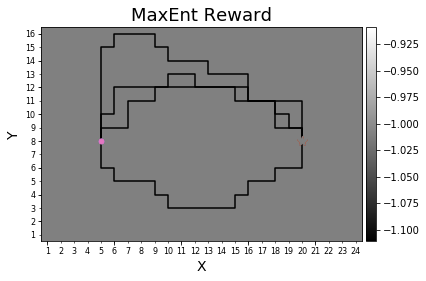

In [62]:
R_model = Models.LinearRewardModel_ReLU(phi_dim, -1.01, steep=1.)
R_model.apply(lambda x: weights_init(x, mu=-1, std=1e-12))
R_grid = convert_to_grid(nvmdp_irl, S, torch.tensor([R_model(phi_fn(s)) for s in S], requires_grad=False))
nvmdp_irl.visualize_grid(cmap=plt.cm.gray, show_colorbar=True, plot=False,
                             trajectories=trajectories_states,
                             init_marker=".", end_marker="*", 
                             traj_marker="-k", traj_colors_auto=False,
                             title="MaxEnt Reward", values=R_grid,
                             state_space_cmap=False)

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x134916c18>)

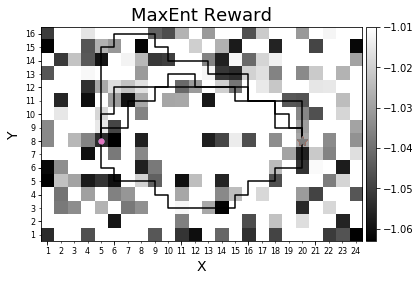

In [63]:
R_model = Models.LinearRewardModel_ReLU(phi_dim, -1.01, steep=1.)
# R_model.apply(lambda x: weights_init(x, mu=-1, std=1e-12))
R_grid = convert_to_grid(nvmdp_irl, S, torch.tensor([R_model(phi_fn(s)) for s in S], requires_grad=False))
nvmdp_irl.visualize_grid(cmap=plt.cm.gray, show_colorbar=True, plot=False,
                             trajectories=trajectories_states,
                             init_marker=".", end_marker="*", 
                             traj_marker="-k", traj_colors_auto=False,
                             title="MaxEnt Reward", values=R_grid,
                             state_space_cmap=False)

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13568dd68>)

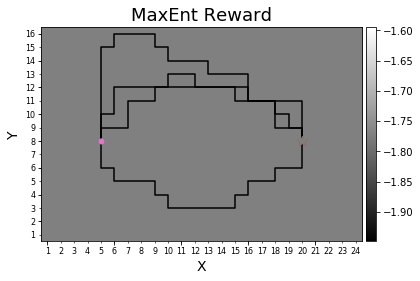

In [74]:
R_model = Models.LinearRewardModel_Tanh(phi_dim, -1.01, steep=1.)
R_model.apply(lambda x: weights_init(x, mu=-1, std=1e-12))
R_grid = convert_to_grid(nvmdp_irl, S, torch.tensor([R_model(phi_fn(s)) for s in S], requires_grad=False))
nvmdp_irl.visualize_grid(cmap=plt.cm.gray, show_colorbar=True, plot=False,
                             trajectories=trajectories_states,
                             init_marker=".", end_marker="*", 
                             traj_marker="-k", traj_colors_auto=False,
                             title="MaxEnt Reward", values=R_grid,
                             state_space_cmap=False)

In [77]:
# R_grid

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x137bd6630>)

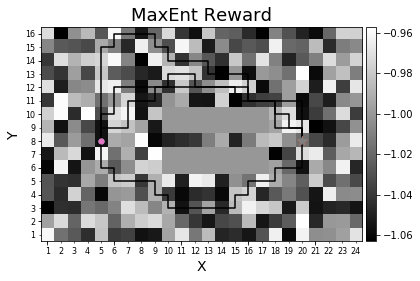

In [69]:
R_model = Models.LinearRewardModel_Tanh(phi_dim, -1.01, steep=1.)
# R_model.apply(lambda x: weights_init(x, mu=-1, std=1e-12))
R_grid = convert_to_grid(nvmdp_irl, S, torch.tensor([R_model(phi_fn(s)) for s in S], requires_grad=False))
nvmdp_irl.visualize_grid(cmap=plt.cm.gray, show_colorbar=True, plot=False,
                             trajectories=trajectories_states,
                             init_marker=".", end_marker="*", 
                             traj_marker="-k", traj_colors_auto=False,
                             title="MaxEnt Reward", values=R_grid,
                             state_space_cmap=False)

In [90]:
np.random.seed(1)
torch.manual_seed(1)
# R model 
# R_model = Models.LinearRewardModel_ReLU(phi_dim, -1.01, steep=1.)
# R_model = Models.LinearRewardModel_Tanh(phi_dim, -1.01, steep=1.)
R_model = Models.LinearRewardModel_Squared_ReLU(phi_dim, -2.01, steep=0.05)
R_model.apply(lambda x: weights_init(x, mu=-1, std=1e-12)) # std = 0 => constant reward function with all mass at mu.

with torch.no_grad():
    R_grid_init = convert_to_grid(nvmdp_irl, S, torch.tensor([R_model(phi_fn(s)) for s in S], requires_grad=False))

# Test: non-positive R
assert np.alltrue(np.asarray([R_model(torch.FloatTensor(x)).item() for x in np.random.uniform(-10,10,(100,phi_dim))]) <= 0)
# Optimizer
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)

maxent_loss_history, maxent_learned_policies, maxent_log_likelihoods, maxent_vi_iters = MaxEntIRL(
    trajectories, states_generator, dynamics_generator, A, phi_fn, 
    R_model, R_optimizer, gamma, n_maxent_iters, n_vi_iters, boltzmann_temp=temperature,
    verbose=True, debug=False, insane_debug=False, vi_convergence_eps=vi_convergence_eps)

maxent_R_grid = convert_to_grid(nvmdp_irl, S, torch.tensor([R_model(phi_fn(s)) for s in S], requires_grad=False))

MaxEntIRL params 
-----
	 Domains: 4, sizes: [384, 384, 384, 384],
	 Action dim: 4, 
	 Feature dim: 353,
	 Iterations: 10, 
	 Max likelihood: 0.99,
	 VI iterations: 150, 
	 VI convergence eps: 0.0001,
	 Gamma (discount factor): 0.97,
Running Backward Pass  [ .. ] Backward pass converged @ 78.
Running Backward Pass  [ .. ] Backward pass converged @ 78.
Running Backward Pass  [ .. ] Backward pass converged @ 78.
Running Backward Pass  [ .. ] Backward pass converged @ 78.

>>> Iter: 0000 (8.411s): loss = 00.003904, likelihood = 0.0000


Running Backward Pass  [ .. ] Backward pass converged @ 77.
Running Backward Pass  [ .. ] Backward pass converged @ 77.
Running Backward Pass  [ .. ] Backward pass converged @ 77.
Running Backward Pass  [ .. ] Backward pass converged @ 77.

>>> Iter: 0001 (8.189s): loss = 00.003855, likelihood = 0.0000


Running Backward Pass  [ .. ] Backward pass converged @ 75.
Running Backward Pass  [ .. ] Backward pass converged @ 75.
Running Backward Pass  [ .. ] Back

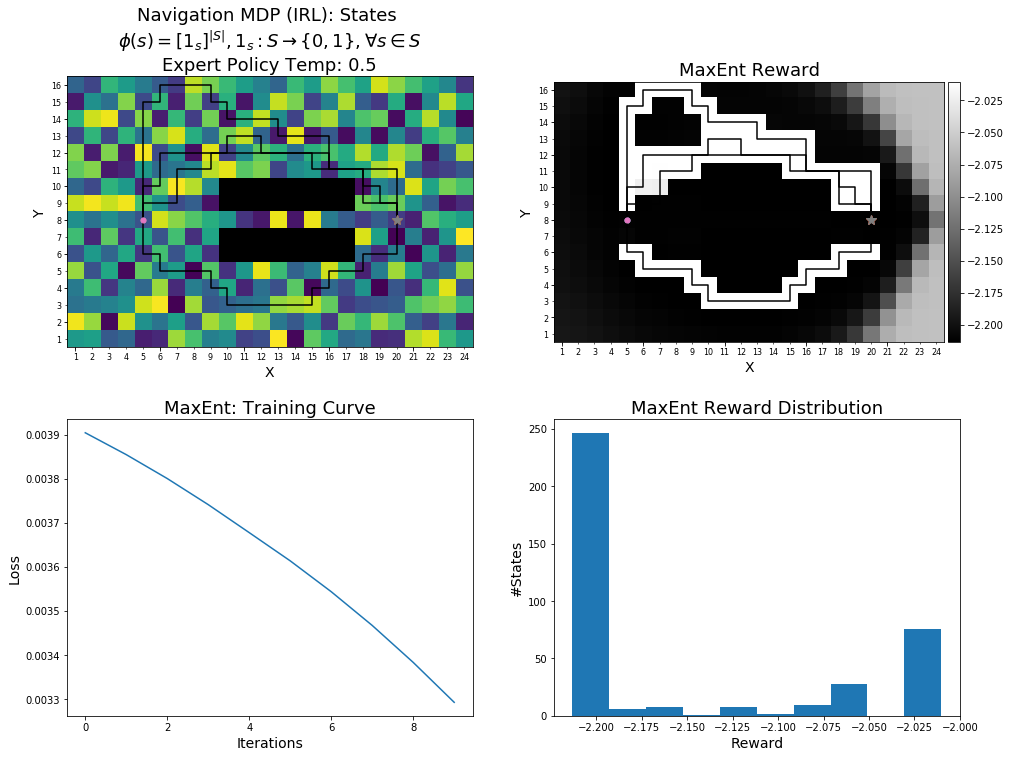

In [91]:
maxent_R_grid = convert_to_grid(nvmdp_irl, S, torch.tensor([R_model(phi_fn(s)) for s in S], requires_grad=False))

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(221)
fig, ax = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.viridis, plot=False, 
                                   trajectories=trajectories_states,
                                   init_marker=".", end_marker="*", 
                                   traj_marker="-k", traj_colors_auto=False,
                                   title=\
        "Navigation MDP (IRL): States \n" +\
        r"$ \phi(s) = [1_s]^{|S|}, 1_s: S \rightarrow \{0,1\},\forall s \in S$" +\
        "\nExpert Policy Temp: {}".format(EXPERT_TEMP))

ax = fig.add_subplot(222)
_ = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.gray, show_colorbar=True, plot=False,
                             trajectories=trajectories_states,
                             init_marker=".", end_marker="*", 
                             traj_marker="-k", traj_colors_auto=False,
                             title="MaxEnt Reward", values=maxent_R_grid,
                             state_space_cmap=False)
ax = fig.add_subplot(223)
plt.plot(maxent_loss_history)
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.title("MaxEnt: Training Curve")

ax = fig.add_subplot(224)
plt.hist(maxent_R_grid.reshape(1,-1).squeeze())
plt.ylabel("#States")
plt.xlabel("Reward")
plt.title("MaxEnt Reward Distribution")
plt.show()

In [32]:
# # ---------------
# # 3D surface plot 
# # ---------------
# def get_xyz(img_2d):
    
#     x_list, y_list, z_list = [], [], []
#     for row in range(len(img_2d)):
#         for col in range(len(img_2d[0])):
#             x, y = row, col
#             x_list.append(x)
#             y_list.append(y)
#             z_list.append(img_2d[row, col])
#     return x_list, y_list, z_list

# def plot_3d_surface(img_2d, fig, zlim=(-3,-1), view=(25, -110), cmap=plt.cm.jet):
#     """
#     Ref: https://python-graph-gallery.com/371-surface-plot/
#     """
#     X, Y, Z = get_xyz(img_2d)
#     # ax = fig.add_subplot(122)
#     ax = fig.gca(projection='3d')
#     ax.plot_trisurf(Y, X, Z, cmap=plt.cm.jet, linewidth=0.2)
#     ax.set_zlim(*zlim)
    
#     ax.invert_yaxis()
#     ax.view_init(*view)
    
#     # to Add a color bar which maps values to colors.
#     surf=ax.plot_trisurf(Y, X, Z, cmap=plt.cm.jet, linewidth=0.2)
#     fig.colorbar(surf, shrink=0.5, aspect=5)
    
# fig = plt.figure(figsize=(20,20))
# plot_3d_surface(maxent_R_grid, fig)
# plt.show()

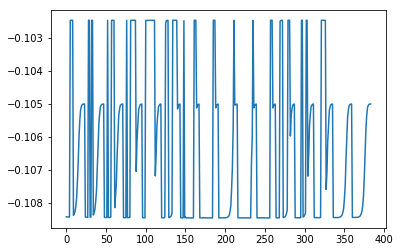

In [33]:
plt.plot(maxent_R_grid.reshape(-1,1).squeeze())

(array([194.,   9.,   9.,   8.,  13.,  79.,   0.,   0.,   0.,  72.]),
 array([-0.10845558, -0.10785617, -0.10725676, -0.10665735, -0.10605794,
        -0.10545853, -0.10485912, -0.10425971, -0.1036603 , -0.10306089,
        -0.10246148]),
 <a list of 10 Patch objects>)

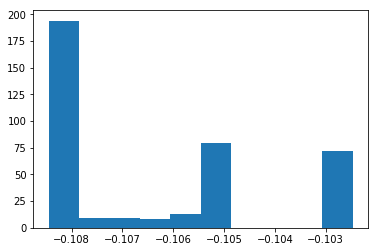

In [34]:
plt.hist(maxent_R_grid.reshape(-1,1).squeeze())

# MLIRL

In [92]:
temperature = 1.

In [ ]:
np.random.seed(1)
torch.manual_seed(1)
# R model
# R_model = Models.LinearRewardModel_Tanh(phi_dim, -1.01, steep=1.)
# R_model = Models.LinearRewardModel_ReLU(phi_dim, out_bias=-0.01, gain=1., steep=0.01, invert=True)
R_model = Models.LinearRewardModel_Squared_ReLU(phi_dim, -2.01, steep=0.005)
R_model.apply(lambda x: weights_init(x, mu=-1.0, std=1e-12))
# for p in R_model.parameters():
#     print(p)
# Test: non-positive R
assert np.alltrue(np.asarray([R_model(torch.FloatTensor(x)).item() for x in np.random.uniform(-10,10,(100,phi_dim))]) <= 0)
# Optimizer
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)

policy = lambda Q, temp=temperature: Planners.log_boltzmann_dist(Q, temp)

mlirl_loss_history, mlirl_learned_policies, mlirl_log_likelihoods_history, mlirl_vi_iters = MLIRL(
                trajectories, states_generator, dynamics_generator, A, phi_fn, R_model, R_optimizer, 
                policy, gamma, n_mlirl_iters, n_vi_iters, verbose=True, 
    vi_convergence_eps=vi_convergence_eps)

MLIRL params 
-----
	 Domains: 4, sizes: [384, 384, 384, 384],
	 Action dim: 4, 
	 Feature dim: 353,
	 Iterations: 10, 
	 Max likelihood: 0.99,
	 VI iterations: 150, 
	 VI convergence eps: 0.0001,
	 Gamma (discount factor): 0.97, 
	 Policy example: Q tensor([0.0000, 0.3333, 0.6667, 1.0000]) -> Pi tensor([-1.9547, -1.6213, -1.2880, -0.9547])
R max:  -2.015000104904175  R min:  -2.015000104904175
Running VI [ .... ] VI didn't converge by 150.
V max:  0.0  V min:  -41.744407653808594
R max:  -2.015000104904175  R min:  -2.015000104904175
Running VI [ .... ] VI didn't converge by 150.
V max:  0.0  V min:  -41.744407653808594
R max:  -2.015000104904175  R min:  -2.015000104904175
Running VI [ .... ] VI didn't converge by 150.
V max:  0.0  V min:  -41.744407653808594
R max:  -2.015000104904175  R min:  -2.015000104904175
Running VI [ .... ] VI didn't converge by 150.
V max:  0.0  V min:  -41.744407653808594

>>> Iter: 0000 (203.066s): loss = 123.722160, likelihood = 0.0000


R max:  -2.01405

In [ ]:
mlirl_R_grid = convert_to_grid(nvmdp_irl, S, torch.tensor([R_model(phi_fn(s)) for s in S], requires_grad=False))

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(221)
fig, ax = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.viridis, plot=False, 
                                   trajectories=trajectories_states,
                                   init_marker=".", end_marker="*", 
                                   traj_marker="-k", traj_colors_auto=False,
                                   title="Navigation MDP (IRL): States\n" + r"$ \phi(s) = [1_s]^{|S|}, 1_s: S \rightarrow \{0,1\},\forall s \in S$")
ax = fig.add_subplot(222)
_ = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.gray, show_colorbar=True, plot=False,
                             trajectories=trajectories_states,
                             init_marker=".", end_marker="*", 
                             traj_marker="-k", traj_colors_auto=False,
                             title="Navigation MDP (IRL): MLIRL Reward", values=mlirl_R_grid,
                             state_space_cmap=False)
ax = fig.add_subplot(223)
plt.plot(np.exp(-np.asarray(mlirl_loss_history)))
plt.ylabel("Likelihood")
plt.xlabel("Iterations")
plt.title("MLIRL: Training Curve")
plt.show()

In [ ]:
import seaborn as sns

In [ ]:
fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(331)
fig, ax = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.viridis, plot=False, 
                                   trajectories=trajectories_states,
                                   init_marker=".", end_marker="*", 
                                   traj_marker="-k", traj_colors_auto=False,
                                   title=\
        "Navigation MDP (IRL): States\n" +\
        r"$ \phi(s) = [1_s]^{|S|}, 1_s: S \rightarrow \{0,1\},\forall s \in S$" +\
        "\nExpert Policy Temp: {}".format(EXPERT_TEMP))

ax = fig.add_subplot(332)
fig, ax = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.gray, plot=False, 
                             title="Reward (unknown)", values=convert_to_grid(nvmdp_irl, S, R_real), 
                             state_space_cmap=False, show_colorbar=True)
ax = fig.add_subplot(333)
sns.distplot(R_grid_init.reshape(1,-1).squeeze(), hist=True, kde=False, bins=10)
# plt.hist(R_grid_init.reshape(1,-1).squeeze(), 100, density=1)
plt.ylabel("#States")
plt.xlabel("Reward")
plt.title("Learner's reward (initial) distribution.")


ax = fig.add_subplot(334)
plt.plot(mlirl_loss_history, "r", label="loss")
plt.plot(mlirl_loss_history, "ro")
plt.grid(True)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.axis('tight')
plt.legend()
ax_2 = ax.twinx()
plt.plot(np.exp(-np.asarray(mlirl_loss_history)), "g",label="likelihood")
plt.plot(np.exp(-np.asarray(mlirl_loss_history)), "go")
plt.xlabel("Iterations")
plt.ylabel("Likelihood")
plt.legend()
plt.axis('tight')
plt.title("MLIRL: Training Curve")


ax = fig.add_subplot(335)
_ = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.gray, show_colorbar=True, plot=False,
                             trajectories=trajectories_states,
                             init_marker=".", end_marker="*", 
                             traj_marker="-k", traj_colors_auto=False,
                             title="Navigation MDP (IRL): MLIRL Reward", values=mlirl_R_grid,
                             state_space_cmap=False)

ax = fig.add_subplot(336)
sns.distplot(mlirl_R_grid.reshape(1,-1).squeeze(), hist=True, kde=True, bins=10)
# plt.hist(mlirl_R_grid.reshape(1,-1).squeeze(), 100, density=1)
plt.ylabel("#States")
plt.xlabel("Reward")
plt.title("MLIRL: Reward Distribution")

ax = fig.add_subplot(337)
plt.plot(maxent_loss_history, "r", label="loss")
plt.plot(maxent_loss_history, "ro")
plt.grid(True)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.axis('tight')
plt.legend()
ax_2 = ax.twinx()
plt.plot(np.exp(np.asarray(maxent_log_likelihoods)), "g",label="likelihood")
plt.plot(np.exp(np.asarray(maxent_log_likelihoods)), "go")
plt.xlabel("Iterations")
plt.ylabel("Likelihood")
plt.legend()
plt.axis('tight')
plt.title("MaxEnt: Training Curve")

ax = fig.add_subplot(338)
_ = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.gray, show_colorbar=True, plot=False,
                             trajectories=trajectories_states,
                             init_marker=".", end_marker="*", 
                             traj_marker="-k", traj_colors_auto=False,
                             title="Navigation MDP (IRL): MaxEnt Reward", values=maxent_R_grid,
                             state_space_cmap=False)

ax = fig.add_subplot(339)
sns.distplot(maxent_R_grid.reshape(1,-1).squeeze(), hist=True, kde=True, bins=10)
# plt.hist(maxent_R_grid.reshape(1,-1).squeeze(), 100, density=1)
plt.ylabel("#States")
plt.xlabel("Reward")
plt.title("MaxEnt: Reward Distribution")

plt.suptitle("11x11 Navigation grid experiment."
             " (Learning rate: {}, weight decay: {}"
             "\n Gamma: {:2.3f}, #max backups: {},"
             " mlirl iters: {}, maxent iters: {}"
             "\n VI convergence eps: {})".format(lr, weight_decay, gamma, n_vi_iters, n_mlirl_iters, n_maxent_iters, vi_convergence_eps))

fig.tight_layout()

### Temperature is reward scale (proof of previous theoretical derivation)

In [46]:
torch.exp(policy(torch.FloatTensor([1,1,1,2])*0.1, 1.)) # low reward scale, more noisy policy => low temp

tensor([0.2436, 0.2436, 0.2436, 0.2692])

In [47]:
torch.exp(policy(torch.FloatTensor([1,1,1,2])*10, 1.)) # higher reward scale, less noisy policy => high temp

tensor([0.0000, 0.0000, 0.0000, 0.9999])

$Temp \propto 1/R_{scale}$  
R_scale higher => Temp lower  
R_scale lower => Temp higher

**Low temperature VI converges faster.**

**Values are like cost to goal, so to sample high temperature trajectories, run VI with high temperature policy, use the values as cost in any shortest path algorithm.**

**Discount factor and temperature are related. At higher temperature, there's less pull from the goal, so need to increase gamma to generate/incentivize reasonable paths/trajectories.**

**|R_max| and gamma are related. If the R_min is too low, that is costs are too high for obstacles, we will need higher discounting factor to generate enough pull so paths lead to goal and are not scared of the costs.**

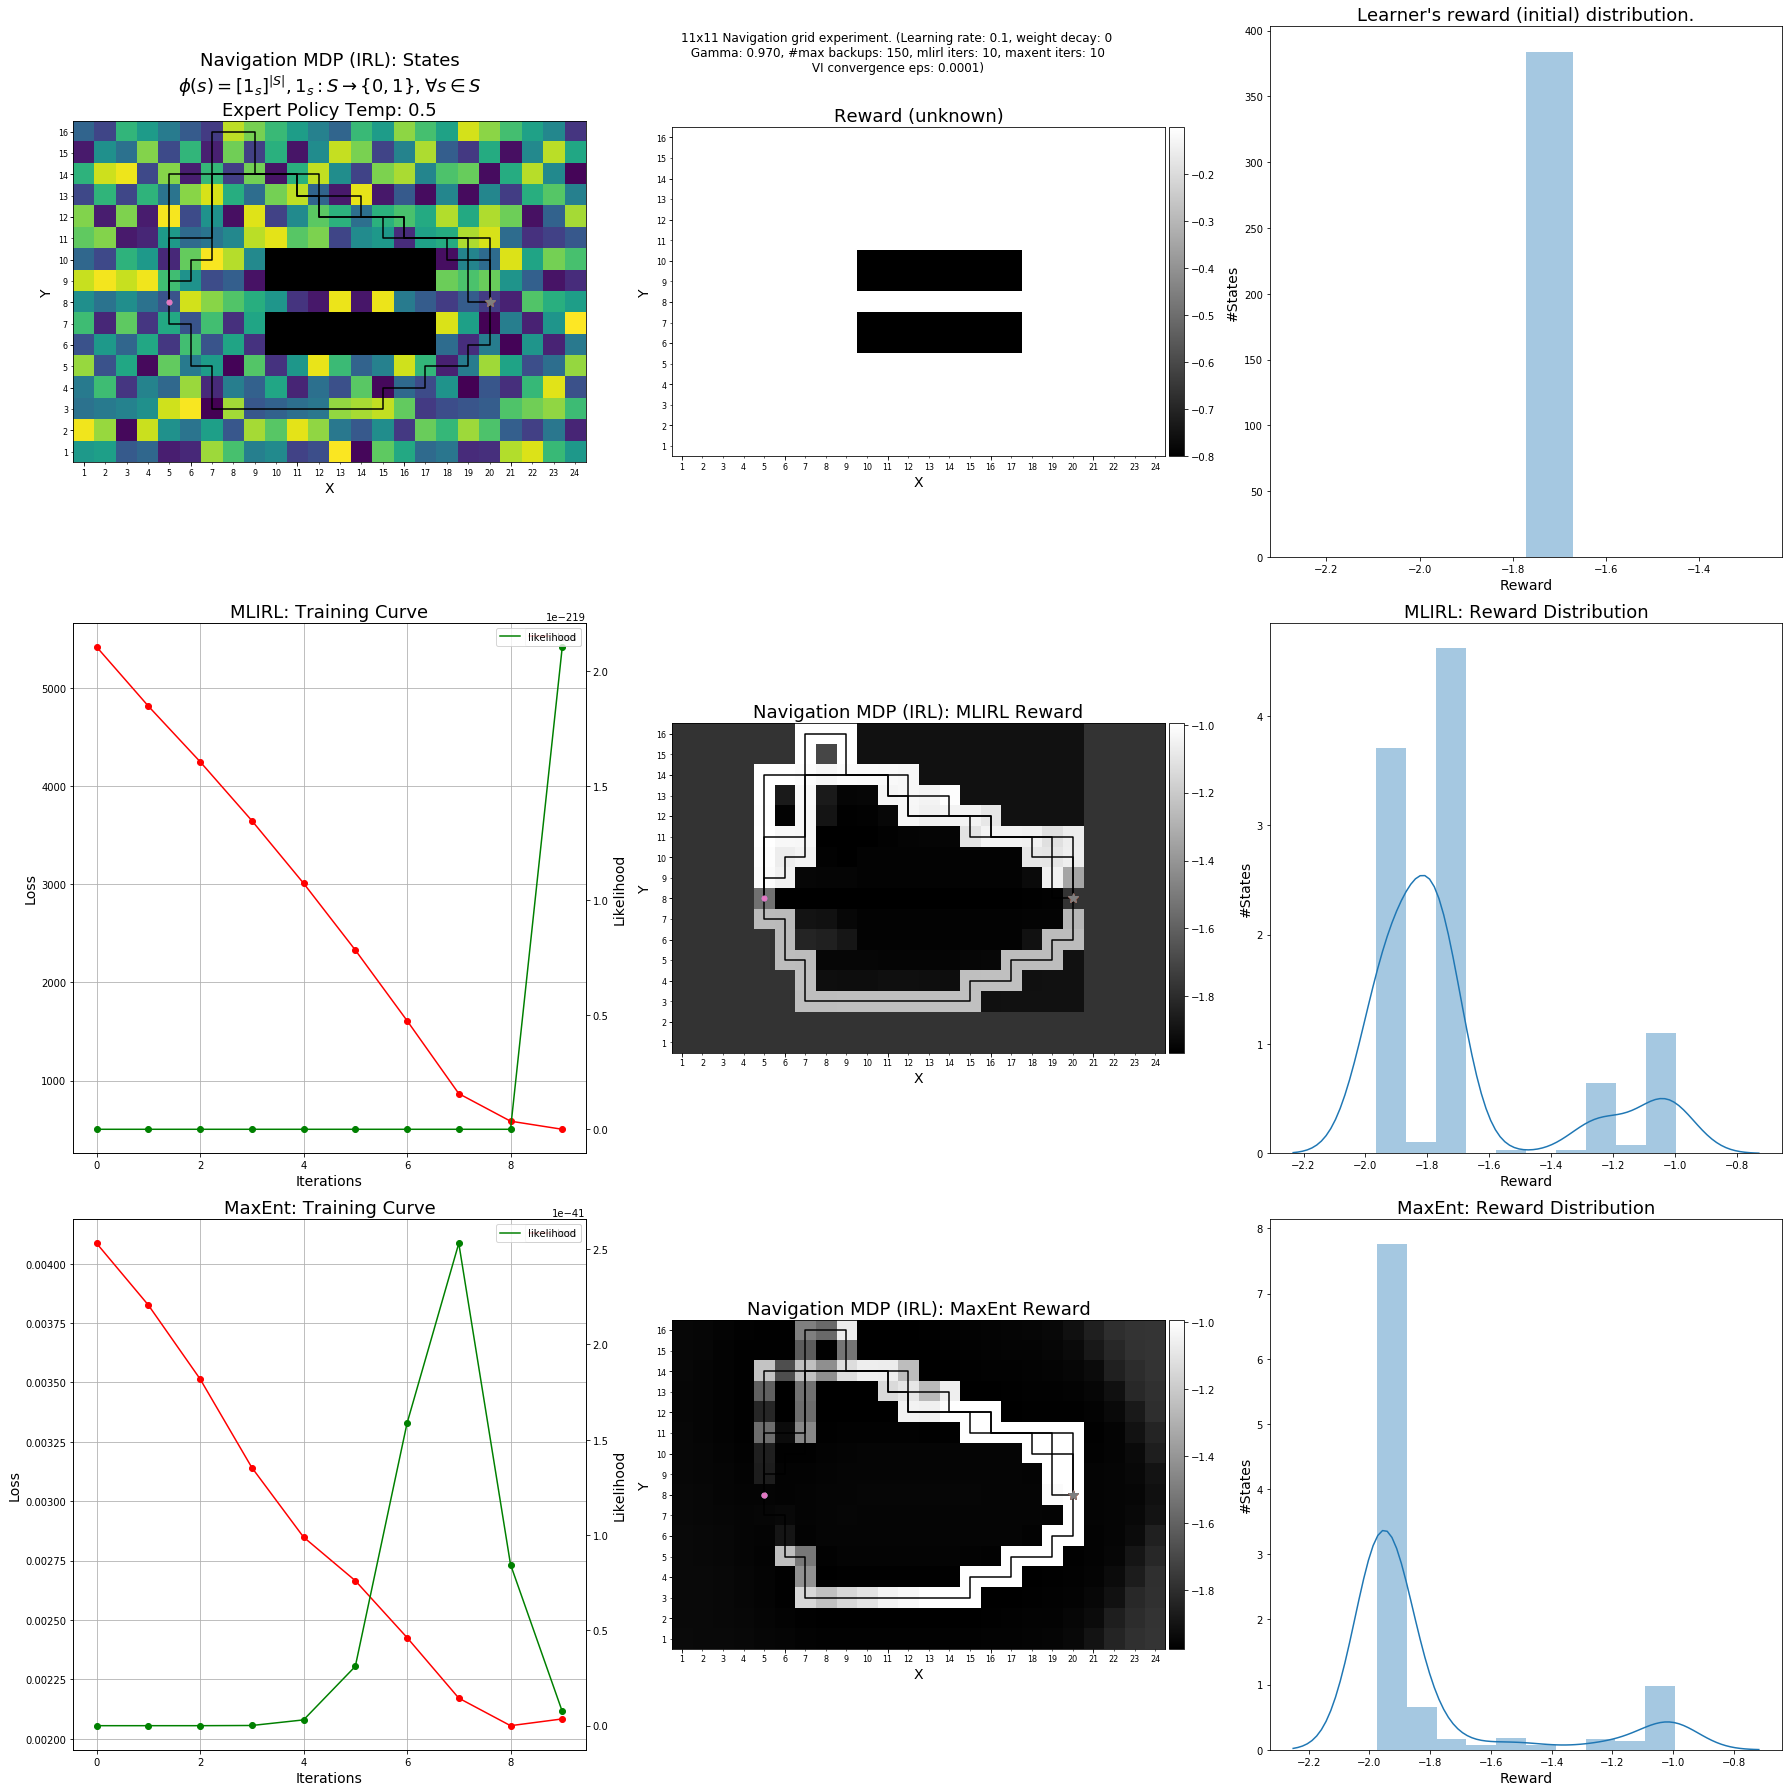

If behavior is correlated with state features, both IRL algorithms will try to explain it in terms of reward assigned to those features. 

Any suboptimality in expert behavior can either be explained with features or cannot be explained with features. If it can be explained with features, we can't refute the explaination. If it cannot be explained with features, we can't model it. 

In IRL, ultimately it's the reward that we're trying to model. If behavior shows indifferent to features (and hence rewards), then we have no way to capture it.

I was barking up the wrong tree. Expert or learner policy temperature isn’t a major problem.

There's two things 

When expert behavior is sub-optimal (to be precise, if learner's feels so because we only observe trajectories not any performance metric), there can be only two possibilities in the context of IRL: 
1) The behavior can be explained using features i.e., features are correlated with the sub-optimal behavior.
Or, 2) The behavior cannot be explained with features i.e., the sub-optimal behavior has no relation with features.



In contrast, consider an expert driving around a building but making a safe distance. 


Both IRL algorithms, MaxEnt and MLIRL, modulate temperature with the rewards. That is, they try to seek to weight features so that reward explains behaviors, and hence are also limited in the sense that they can only model behaviors that can be explained with features. So is sub-optimality has no relation with physical state features, they can’t model it, that is, such behaviors will be perceived as sub-optimal unless more features are available to reason. It's also a hint to the learner that there's more in the world to be explored.

Which is not bad, because the behavior which isn’t related with state features can also be called irrational, serving no purpose (in general, not contributing to energy minimization objective). So if we don’t learn irrational behaviors, that’s not a problem, we don’t want to learn irrational things. 

Rational behavior should be justified using available features. If it’s rational and it isn’t justified then it indicates that the features are insufficient.

In addition, we believe that experts are optimal, so if there’s any sub-optimality, it must be in learner’s perception (or expert’s energy minimization preferences), the perception should be changed.

If it can be explained with features, we can’t refute the . If it cannot be explained with features, we can’t model it. 

**The higher the initial negative reward, the faster it converged!**